In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas
from create_train_test_val_maps import *
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

In [2]:
# get global index from (row, col) index
def sub2ind(array_shape, row, col):
    ind = row*array_shape[1] + col
    if row < 0 or row >= array_shape[0]:
        ind = -1
    if col < 0 or col >= array_shape[1]:
        ind = -1
    return ind

# get (row, col) index from global index
def ind2sub(array_shape, ind):
    row = int(ind) / array_shape[1]
    col = ind % array_shape[1]
    if ind < 0:
        row = -1
        col = -1
    if ind >=  array_shape[0]*array_shape[1]:
        row = -1
        col = -1
    return (row, col)

def one_hot_labels(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

def get_data(selected_codes, data_map, num_windows, window_size):
    X = []
    Y = []
    for vehicleID in data_map.keys():
        for ATA6code in data_map[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for window in data_map[vehicleID][ATA6code].keys():
                for sequence in data_map[vehicleID][ATA6code][window]:
                    seq_len = len(sequence)
                    Y.extend(list(np.ones((seq_len))*sub2ind((len(selected_codes),num_windows),selected_codes.index(ATA6code), window)))
                    X.extend(sequence.as_matrix())
    X = np.array(X).astype(float)
    Y = np.array(Y).astype(int)
    return X, Y

def create_two_stage_models(num_trees_code, num_trees_window, codes):
    code_clfs = {}
    window_clfs = {}
    for code in codes:
        code_clfs[code] = RandomForestClassifier(n_estimators=num_trees_code, n_jobs=-1, random_state=0, class_weight='balanced')
        window_clfs[code] = RandomForestClassifier(n_estimators=num_trees_window, n_jobs=-1, random_state=0, class_weight='balanced')
    return code_clfs, window_clfs


def create_one_stage_models(num_trees_code, codes):
    code_clfs = {}
    for code in codes:
        code_clfs[code] = RandomForestClassifier(n_estimators=num_trees_code, n_jobs=-1, random_state=0, class_weight='balanced')
    return code_clfs

def get_one_v_all_batches(selected_codes, data_map, num_windows, window_size):
    # returns Y_map {code -> X in {0/1}}
    # returns X all sequences
    X = []
    X_map = {}
    Y = []
    Y_map = {}
    for code in selected_codes:
        Y_map[code] = []
        X_map[code] = []
        
    for veh_id in data_map.keys():
        for code in selected_codes:
            if code not in data_map[veh_id].keys():
                continue
            for window in data_map[veh_id][code].keys():
                for sequence in data_map[veh_id][code][window]:
                    seq_len = len(sequence)
                    seq_mat = sequence.as_matrix()
                    X.extend(seq_mat)
                    X_map[code].extend(seq_mat)
                    
                    Y.extend(list(np.ones((seq_len))*code))

                    for map_code in selected_codes:
                        y_code = None
                        if code == map_code:
                            y_code = np.ones((seq_len))
                        else:
                            y_code = np.zeros((seq_len))

                        Y_map[map_code].extend(y_code)
    
    for code in selected_codes:
        Y_map[code] = np.array(Y_map[code]).astype(int)
        X_map[code] = np.array(X_map[code]).astype(float)
    X = np.array(X).astype(float)
    Y = np.array(Y).astype(int)
    return X, X_map, Y, Y_map

def save_file(filename, m):
    with open(filename+'.pkl', 'wb') as handle:
        pickle.dump(m, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def open_file(filename):
    m = None
    with open(filename+'.pkl', 'rb') as handle:
        m = pickle.load(handle)
    return m

In [3]:
selected_codes = [0, 45021, 44004, 43004, 45008, 45002, 45007]

In [69]:
## selected windows to report on
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
trees = [10,60, 100,200,300]#[10, 30, 40, 50, 60, 70, 100]
np_codes = np.asarray(selected_codes)

val_acc_all = {}
val_error_all = {}

for num_windows, window_size in hyper_tuples:
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)

    val_acc_all[(num_windows,window_size)] = {}
    val_acc_trees = val_acc_all[(num_windows,window_size)]
    val_error_all[(num_windows,window_size)] = {}
    val_error_trees = val_error_all[(num_windows,window_size)]
    
    X_train, X_train_map, y_train, y_train_map = get_one_v_all_batches(selected_codes, train_combined, num_windows, window_size)
    X_val, X_val_map, y_val, y_val_map = get_one_v_all_batches(selected_codes, val_combined, num_windows, window_size)
    
    for num_trees in trees:
        print("Training tree {} with num {} and size {}".format(num_trees, num_windows, window_size))
        
        code_clfs = create_one_stage_models(num_trees, selected_codes)

        val_acc_trees[num_trees] = {}
        
        #train & val
        predictions = np.zeros((X_val.shape[0], len(selected_codes)))
        for i,code in enumerate(selected_codes):
            # train
            code_clfs[code].fit(X_train, y_train_map[code])
            
            # val recall
            val_acc_trees[num_trees][code] = np.sum(np.argmax(code_clfs[code].predict_proba(X_val_map[code]), axis=1) == 1)/len(X_val_map[code])
            
            # val ave
            predictions[:,i] = np.argmax(code_clfs[code].predict_proba(X_val), axis=1)
        
        predictions_choice = np_codes[np.argmax(predictions, axis=1)]
        val_acc_trees[num_trees]['ave'] = np.sum(predictions_choice == y_val)/len(y_val)


Training tree 10 with num 1 and size 500
Training tree 60 with num 1 and size 500
Training tree 100 with num 1 and size 500
Training tree 200 with num 1 and size 500
Training tree 300 with num 1 and size 500
Training tree 10 with num 2 and size 250
Training tree 60 with num 2 and size 250
Training tree 100 with num 2 and size 250
Training tree 200 with num 2 and size 250
Training tree 300 with num 2 and size 250
Training tree 10 with num 5 and size 100
Training tree 60 with num 5 and size 100
Training tree 100 with num 5 and size 100
Training tree 200 with num 5 and size 100
Training tree 300 with num 5 and size 100
Training tree 10 with num 10 and size 50
Training tree 60 with num 10 and size 50
Training tree 100 with num 10 and size 50
Training tree 200 with num 10 and size 50
Training tree 300 with num 10 and size 50


In [70]:
save_file('val_acc_all_1_v_all_per_code_3', val_acc_all)

In [59]:
val_acc_all

{(1,
  500): {10: {0: 1.0,
   45008: 0.0,
   44004: 0.022390754785120981,
   'ave': 0.3742702251876564,
   45002: 0.0,
   43004: 0.0,
   45021: 0.57711368073284275,
   45007: 0.0}, 50: {0: 1.0,
   45008: 0.0,
   44004: 0.039364391477067537,
   'ave': 0.42076730608840701,
   45002: 0.0,
   43004: 0.0,
   45021: 0.6688691995795164,
   45007: 0.0}, 70: {0: 1.0,
   45008: 0.0,
   44004: 0.041892379920548936,
   'ave': 0.42021128718376427,
   45002: 0.0,
   43004: 0.0,
   45021: 0.6672172998948791,
   45007: 0.0}, 100: {0: 1.0,
   45008: 0.0,
   44004: 0.037919826652221017,
   'ave': 0.42743953294412013,
   45002: 0.0,
   43004: 0.0,
   45021: 0.68328577864544227,
   45007: 0.0}, 200: {0: 1.0,
   45008: 0.0,
   44004: 0.038642109064644277,
   'ave': 0.42625799277175425,
   45002: 0.0,
   43004: 0.0,
   45021: 0.68058267007058115,
   45007: 0.0}}}

In [12]:
# take mean of windows
val_mean_map = {}
for tup in hyper_tuples:
    val_mean_map[tup] = {}
    for tree in val_acc_all[tup].keys():
        code_acc = np.mean(list(val_acc_all[tup][tree]['code'].values()))
        window_acc = np.mean(list(val_acc_all[tup][tree]['window'].values()))
        val_mean_map[tup][tree] = [code_acc, window_acc]

In [14]:
# make matrix out of mean scores
score_mat = np.zeros((len(hyper_tuples), len(trees), 2))
s_hyper_tuples = sorted(hyper_tuples)
s_trees = sorted(trees)

for tup in range(len(s_hyper_tuples)):
    for num_trees in range(len(s_trees)):
        mean_tup = val_mean_map[s_hyper_tuples[tup]][s_trees[num_trees]]
        score_mat[tup, num_trees] = np.asarray(mean_tup)

In [170]:
# only use decided upon (1,500), (2,250), (5, 100), (10, 50)
score_mat_red = score_mat[[0,1,4]]
s_hyper_tuples = sorted(hyper_tuples)
s_trees = sorted(trees)
s_hyper_tuples = [s_hyper_tuples[i] for i in [0,1,4]]

In [171]:
# find best trees
best_trees = np.argsort(np.sum(np.sum(score_mat_red, axis=2), axis=0))
for tree_i in best_trees[::-1][:3]:
    print(s_trees[tree_i])

200
100
50


In [142]:
np.sum(score_mat, axis=1)

array([[ 2.78533333,  5.        ],
       [ 2.71502222,  3.18942569],
       [ 2.33171429,  1.51228691],
       [ 2.59763889,  1.66150211],
       [ 2.60773109,  1.7137381 ],
       [ 2.44242254,  1.59003448],
       [ 2.41036415,  1.15189493],
       [ 2.41473684,  1.29455088]])

In [141]:
# multiply each ave accuracy by the granularity to see "best value" for window size
np.mean(np.sum(score_mat, axis=2), axis=1)*np.array(s_hyper_tuples)[:,0]

array([ 1.55706667,  2.36177916,  3.8440012 ,  4.259141  ,  4.32146919,
        4.03245701,  7.12451815,  7.41857544])

In [60]:
def get_plots(Y, x, z_labels, title, xlabel, ylabel, tic_mult=1, offset=0):
    for i in range(len(z_labels)):
        plot_label = z_labels[i]
        plt.plot(x,Y[i],label=plot_label)

    ax = plt.gca() # grab the current axis
    ax.set_xticks(x[offset::tic_mult]) # choose which x locations to have ticks
    ax.set_xticklabels(x[offset::tic_mult]) # set the labels to display at those ticks
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    legend = plt.legend(loc="upper right",bbox_to_anchor=(1,1), title="(#Win,WSize)")
    plt.rcParams["figure.figsize"] = [6,5]
    plt.savefig(title.replace(" ", "_"), bbox_extra_artists=(legend,), bbox_inches="tight")
    plt.show()
    
def get_z_labels(hyper_tuples):
    return [str(tup) for tup in hyper_tuples]

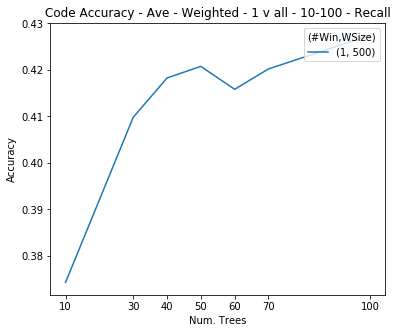

In [67]:
## plot trees plots
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = trees
z_labels = get_z_labels(hyper_tuples)

code_accuracies_list = []
for tup in hyper_tuples:
    code_acc_tup_tree = []
    for tree in trees:
        #vals = [val_acc_all[tup][tree][i] for i in selected_codes]
        code_acc_tup_tree.append(val_acc_all[tup][tree]['ave'])
        
    code_accuracies_list.append(code_acc_tup_tree)

plt.figure()
get_plots(code_accuracies_list, x_coord, z_labels, "Code Accuracy - Ave - Weighted - 1 v all - 10-300", "Num. Trees", "Accuracy")

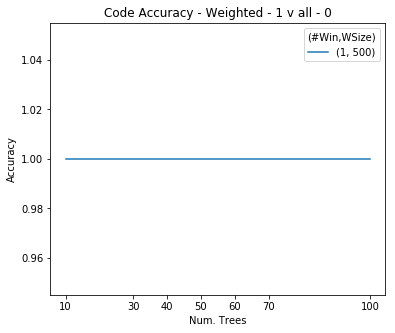

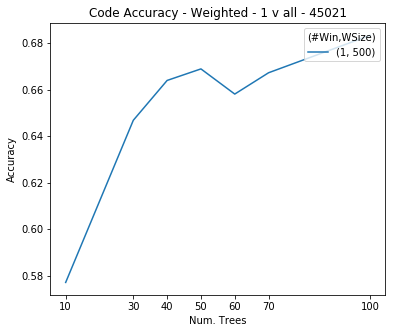

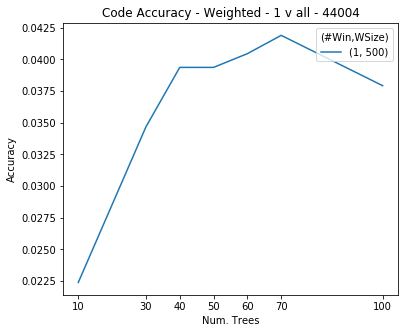

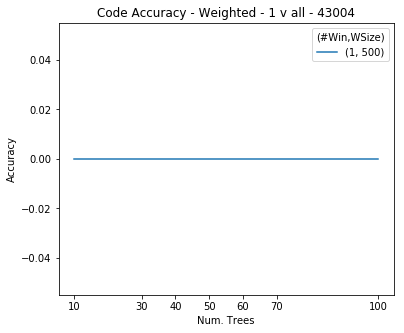

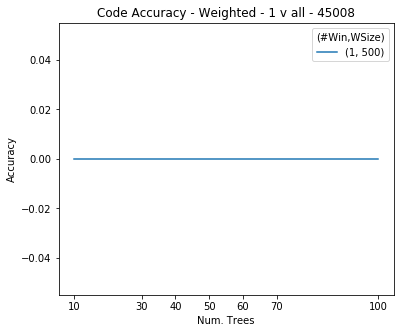

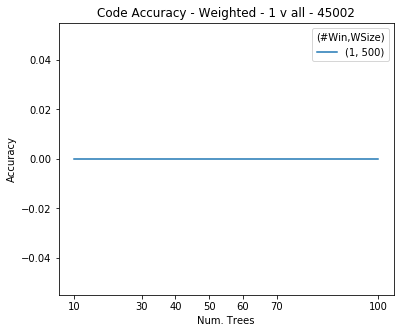

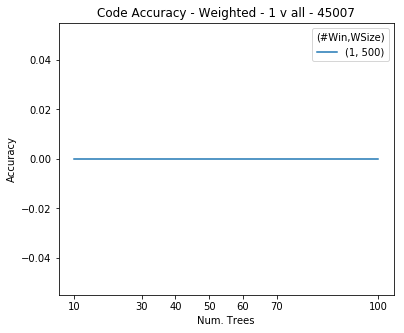

In [68]:
## plot trees with codes plots
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = trees
z_labels = get_z_labels(hyper_tuples)

for code in selected_codes:
    code_accuracies_list = []
    for tup in hyper_tuples:
        code_acc_tup_tree = []
        for tree in trees:
            code_acc_tup_tree.append(val_acc_all[tup][tree][code])
        code_accuracies_list.append(code_acc_tup_tree)

    plt.figure()
    get_plots(code_accuracies_list, x_coord, z_labels, "Code Accuracy - Weighted - 1 v all - 10-300 - {}".format(code), "Num. Trees", "Accuracy")

In [7]:
## determine standard dev, mean for best model for each hyper_tuple

# best number of trees
num_trees_code = 100
num_trees_window = 10

hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
code_scores = {}
window_errors = {}
code_means = {}
code_stds = {}
window_means = {}
window_abs_means = {}
window_stds = {}

for tup in hyper_tuples:
    num_windows, window_size = tup
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
    X_train, X_train_map, y_train, y_train_map = get_one_v_all_batches(selected_codes, train_combined, num_windows, window_size)
    X_test, X_test_map, y_val, y_test_map = get_one_v_all_batches(selected_codes, test_combined, num_windows, window_size)

    # train
    code_clfs = create_one_stage_models(num_trees_code, selected_codes)
    
    # test
    code_scores[tup] = {}

    #train & val
    predictions = np.zeros((X_test.shape[0], len(selected_codes)))
    for i,code in enumerate(selected_codes):
        if len(X_test_map[code])>0:
            # train
            code_clfs[code].fit(X_train, y_train_map[code])

            # test recall
            code_scores[tup][code] = np.sum(np.argmax(code_clfs[code].predict_proba(X_test_map[code]), axis=1) == 1)/len(X_test_map[code])

            # test ave
            predictions[:,i] = np.argmax(code_clfs[code].predict_proba(X_test), axis=1)

    predictions_choice = np_codes[np.argmax(predictions, axis=1)]
    code_scores[tup]['ave'] = np.sum(predictions_choice == y_test)/len(y_test)

    code_means[tup] = np.mean(list(code_scores[tup].values()))
    code_stds[tup] = np.std(list(code_scores[tup].values()))

NameError: name 'np_codes' is not defined

In [238]:
save_file('test_code_scores_opt', code_scores)
save_file('test_window_errors_opt', window_errors)
save_file('test_code_means_opt', code_means)
save_file('test_code_stds_opt', code_stds)
save_file('test_window_means_opt', window_means)
save_file('test_window_abs_means_opt', window_abs_means)
save_file('test_window_stds_opt', window_stds)

In [293]:
window_means

{(1, 500): 0.0,
 (2, 250): 0.27344761904761905,
 (5, 100): 3.0921186758104051,
 (10, 50): 13.654218774657197}

In [294]:
window_stds

{(1, 500): 0.0,
 (2, 250): 0.19231344029923619,
 (5, 100): 2.1566813941904779,
 (10, 50): 8.4453396386850592}

In [295]:
code_means

{(1, 500): 0.42683333333333334,
 (2, 250): 0.31680952380952382,
 (5, 100): 0.34508155002891844,
 (10, 50): 0.31537229437229441}

In [296]:
code_stds

{(1, 500): 0.44622132649865831,
 (2, 250): 0.43684815774496527,
 (5, 100): 0.41833631702481688,
 (10, 50): 0.40151661674625594}

In [328]:
## create comparison matrix for comparison metrics
comparison_matrix = {}
for tup in hyper_tuples:
    if tup == (1,500): # handle zero/zero case
        comparison_matrix[tup] = [(code_means[tup]/code_stds[tup]), 0]
    else:
        comparison_matrix[tup] = [(code_means[tup]/code_stds[tup]), -window_stds[tup]*window_means[tup]]

In [329]:
save_file('comparison_matrix', comparison_matrix)

In [330]:
comparison_matrix

{(1, 500): [0.95655072491165827, 0],
 (2, 250): [0.7252165728359995, -0.052587652360682566],
 (5, 100): [0.82489025213760547, -6.6687148167491985],
 (10, 50): [0.78545265928956154, -115.31451505289017]}

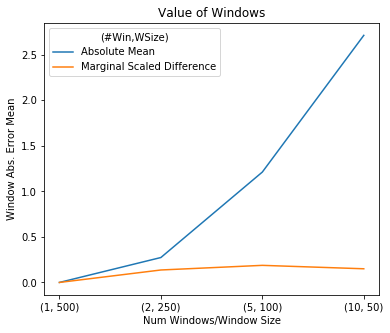

In [281]:
# plot means
plt.figure()

means = [window_abs_means[i] for i in hyper_tuples]

plt.plot(range(len(hyper_tuples)), means, label='Absolute Mean')
diff_start = [0]
diff_start.extend(means)
marginal_difference = [(diff_start[i+1] - diff_start[i])/hyper_tuples[i][0] for i in range(len(hyper_tuples))]
plt.plot(range(len(hyper_tuples)), marginal_difference, label='Marginal Scaled Difference')
ax = plt.gca() # grab the current axis
ax.set_xticks(range(len(hyper_tuples))) # choose which x locations to have ticks
ax.set_xticklabels(hyper_tuples) # set the labels to display at those ticks
plt.xlabel('Num Windows/Window Size')
plt.ylabel('Window Abs. Error Mean')
plt.title('Value of Windows')
plt.rcParams["figure.figsize"] = [6,5]
legend = plt.legend(loc="upper left", title="(#Win,WSize)")
plt.savefig('Value_of_Windows', bbox_extra_artists=(legend,), bbox_inches="tight")
plt.show()

In [258]:
## feature selection prep
col_names = list(test_combined[519][44003][0][0])
features_ind_sort = np.argsort(code_clf.feature_importances_)[::-1]

# best number of trees
num_trees_code = 40
num_trees_window = 10

In [287]:
## feature selection
code_acc_fs = {}
window_err_fs = {}

for tup in hyper_tuples:
    num_windows, window_size = tup
    train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
    X_train, X_train_map, y_train_code, y_train_code_map, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
    X_val, X_val_map, y_val_code, y_val_code_map, y_val_window = get_code_window_batches(selected_codes, val_combined, num_windows, window_size)
    
    code_acc_fs[tup] = {}
    window_err_fs[tup] = {}
    
    for to_keep_ind in range(1,len(col_names)+1):
        features_ind = features_ind_sort[:to_keep_ind]

        # train
        code_clf, window_clfs = create_two_stage_models(num_trees_code, num_trees_window, selected_codes)
        code_clf.fit(X_train[:, features_ind], y_train_code)
        for code in selected_codes:
            window_clfs[code].fit(X_train_map[code][:, features_ind], y_train_window[code])

        # val
        code_acc_fs[tup][to_keep_ind] = {}
        window_err_fs[tup][to_keep_ind] = {}
        for code in selected_codes:
            if len(X_val_map[code])>0:
                code_acc_fs[tup][to_keep_ind][code] = code_clf.score(X_val_map[code][:, features_ind], y_val_code_map[code])
                window_err_fs[tup][to_keep_ind][code] = mean_squared_error(window_clfs[code].predict(X_val_map[code][:, features_ind]), y_val_window[code])

In [289]:
window_err_fs[(2,250)][1]

{0: 0.0,
 43004: 0.33333333333333331,
 44004: 0.55555555555555558,
 45002: 0.5,
 45007: 0.5,
 45008: 0.5,
 45021: 0.48727272727272725}

In [291]:
save_file('feature_selection_acc', code_acc_fs)
save_file('feature_selection_err', window_err_fs)

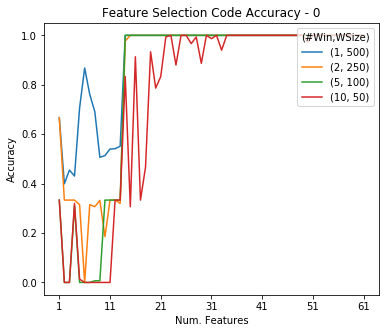

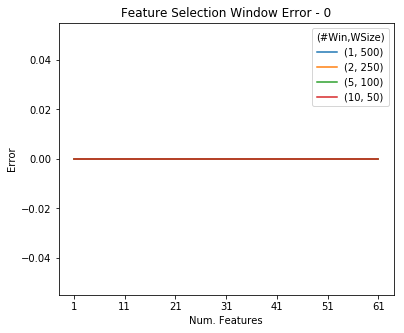

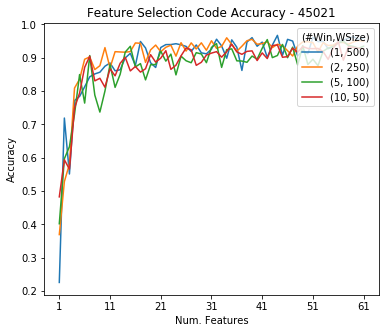

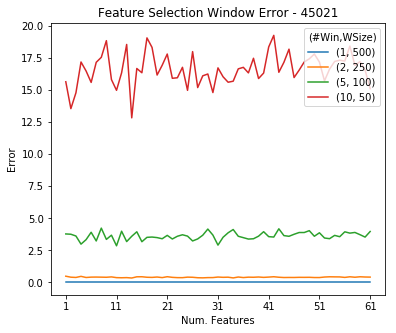

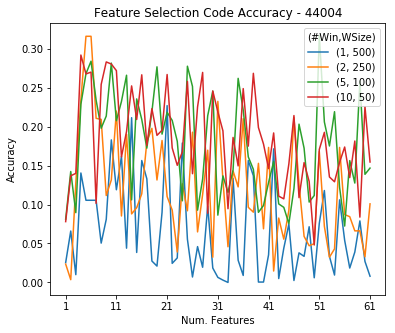

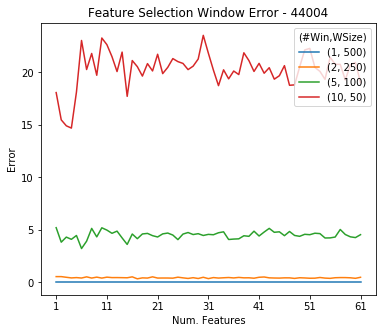

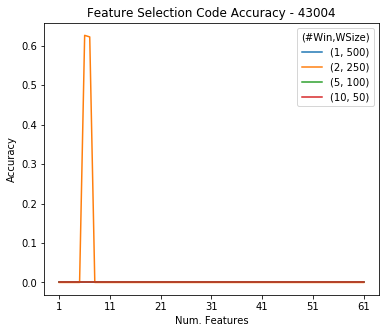

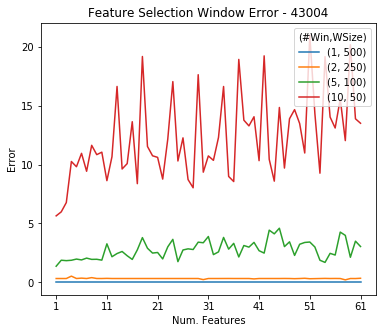

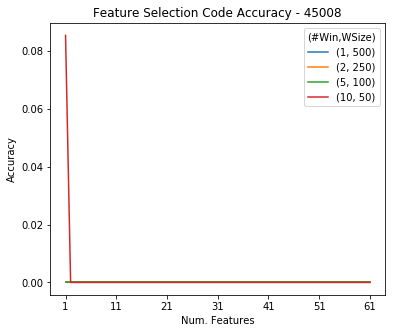

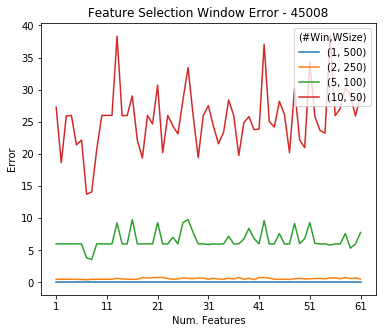

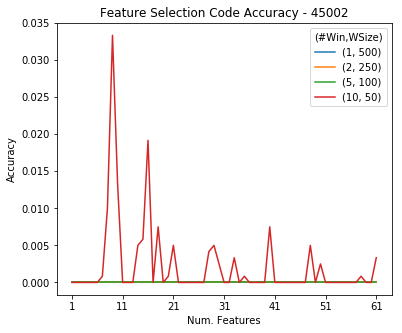

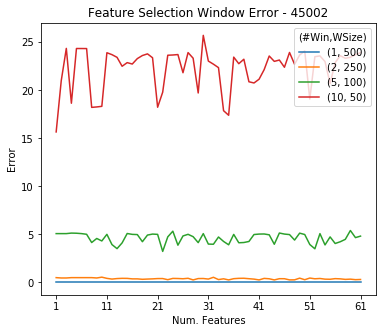

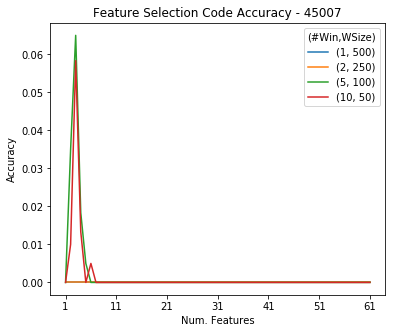

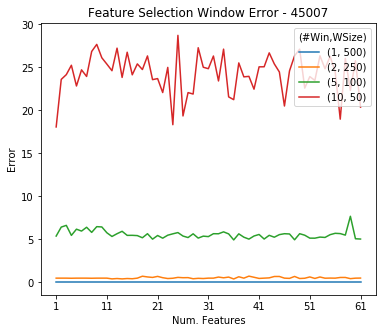

In [292]:
## plot feature selection
hyper_tuples = [(1,500), (2,250), (5,100), (10, 50)]
x_coord = range(1,len(col_names)+1) ## number of features, 61 included, sorted by greatest importance
z_labels = get_z_labels(hyper_tuples)

for code in selected_codes:
    code_accuracies_list = []
    window_errors_list = []
    for tup in hyper_tuples:
        code_acc_tup_ind = []
        window_error_tup_ind = []
        for feat_ind in x_coord:
            code_acc_tup_ind.append(code_acc_fs[tup][feat_ind][code])
            window_error_tup_ind.append(window_err_fs[tup][feat_ind][code])
        
        code_accuracies_list.append(code_acc_tup_ind)
        window_errors_list.append(window_error_tup_ind)

    plt.figure()
    get_plots(code_accuracies_list, x_coord, z_labels, "Feature Selection Code Accuracy - {}".format(code), "Num. Features", "Accuracy", tic_mult=10)

    plt.figure()
    ax = plt.axes()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    get_plots(window_errors_list, x_coord, z_labels, "Feature Selection Window Error - {}".format(code), "Num. Features", "Error", tic_mult=10)

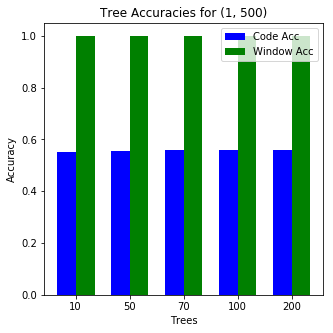

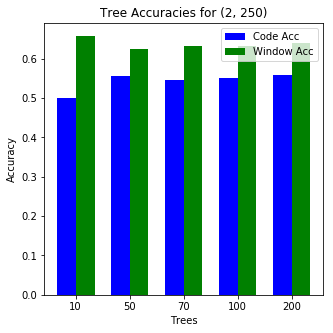

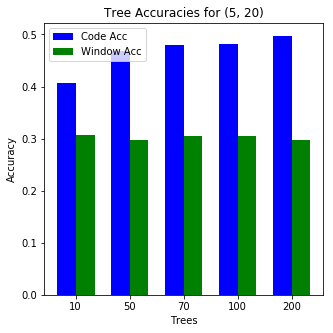

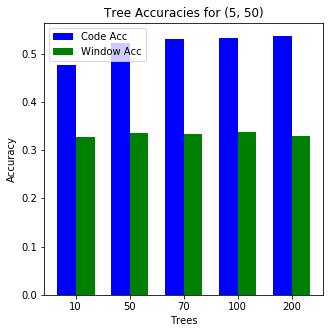

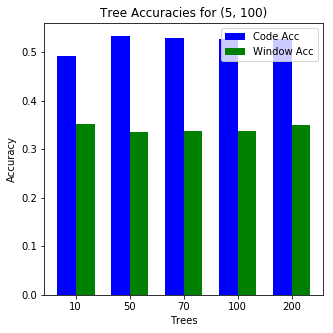

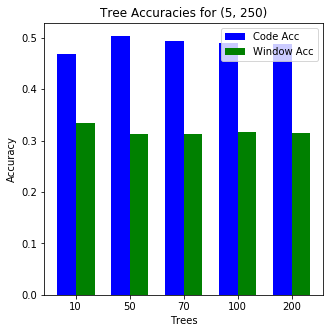

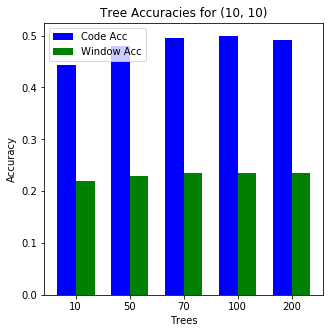

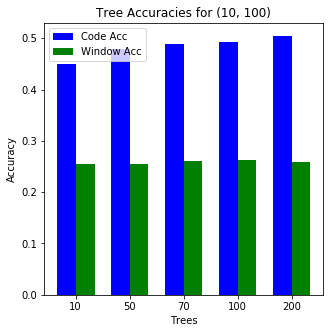

In [90]:
for tup in hyper_tuples:
    tup_key = tup
    tics = sorted(list(val_acc_all[tup].keys()))
    fig, ax = plt.subplots(figsize=(5,5))
    ind = np.arange(len(tics))
    width = 0.35
    code_acc = [val_acc_all[tup_key][key]['code'] for key in tics]
    window_acc = [np.mean(list(val_acc_all[tup_key][key]['window'].values())) for key in tics]
    rects1 = ax.bar(ind, code_acc, width, color='b')
    rects2 = ax.bar(ind + width, window_acc, width, color='g')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trees')
    ax.set_title('Tree Accuracies for {}'.format(tup_key))
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(tics)

    ax.legend((rects1[0], rects2[0]), ('Code Acc', 'Window Acc'))
    plt.show()

In [149]:
# setup with chosen parameters
num_trees = 200
num_windows, window_size = (2, 250)
train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
X_train, X_train_map, y_train_code, _, y_train_window = get_code_window_batches(selected_codes, train_combined, num_windows, window_size)
X_test, X_test_map, y_test_code, y_test_code_map, y_test_window = get_code_window_batches(selected_codes, test_combined, num_windows, window_size)

# train
code_clf, window_clfs = create_two_stage_models(num_trees, num_trees, selected_codes)
code_clf.fit(X_train, y_train_code)
for code in selected_codes:
    window_clfs[code].fit(X_train_map[code], y_train_window[code])

In [148]:
for code in selected_codes:
    print(code, len(X_test_map[code]))

0 1000
45021 1000
44004 500
43004 0
45008 500
45002 500
45007 500


In [150]:
# test
code_scores = {}
window_scores = {}
for code in selected_codes:
    if len(X_test_map[code])>0:
        code_scores[code] = code_clf.score(X_test_map[code], y_test_code_map[code])
        window_scores[code] = window_clfs[code].score(X_test_map[code], y_test_window[code])
    
# features
print(code_clf.feature_importances_)

[  4.68043338e-04   9.22218927e-04   7.20912016e-03   1.39315677e-02
   7.14339888e-05   5.38632474e-02   1.27849396e-03   1.35202870e-03
   6.05820230e-04   1.77382249e-03   1.00518733e-04   1.37900914e-06
   1.23377997e-04   6.81208649e-04   1.49607647e-03   7.80485442e-02
   9.02132590e-05   1.38498104e-03   9.90168690e-04   6.08674782e-03
   1.85260837e-03   1.20632798e-03   5.36166797e-03   2.72644513e-03
   2.20397240e-03   2.05495221e-03   1.61588283e-03   1.46612211e-03
   1.91898960e-03   1.64089754e-03   1.01080545e-03   6.49189627e-04
   1.02186218e-03   1.48713581e-03   9.27229139e-02   1.08272544e-01
   9.13438121e-02   6.95615399e-02   7.32211780e-03   7.68663790e-03
   5.30370404e-03   3.66185493e-03   7.25264615e-04   1.57292344e-03
   1.70205395e-03   1.90335879e-03   1.30406430e-03   1.44762075e-03
   3.04349334e-03   4.49270376e-03   3.40901770e-03   2.77041948e-02
   1.01611441e-02   1.38869640e-02   5.06210998e-02   5.46437486e-02
   5.59368944e-02   5.71285281e-02

In [160]:
col_names = list(test_combined[519][44003][0][0])
[col_names[i] for i in np.argsort(code_clf.feature_importances_)[::-1]]

['Event - Amber Lamp Time Hr',
 'Event - All Lamps On Time Hr',
 'Event - Mil Lamp Time Hr',
 'Eng Avg Fuel Econ',
 'Event - Red Lamp Time Hr',
 'Lifetime Idle Fuel',
 'Lifetime Idle Hours',
 'Longitude',
 'Bus Utilization',
 'Latitude',
 'Lifetime Distance',
 'Lifetime Fuel',
 'Lifetime Engine Hours',
 'Altitude',
 'Barometric Press',
 'Engine Start Coolant',
 'Engine Start Ambient',
 'Exhaust Tank Temp',
 'Exhaust Tank Level',
 'Ambient Air Temp',
 'Eng DPF Intake Press',
 'Eng Fuel Del Press',
 'Fan Speed',
 'Trip Idle Time',
 'Keyswitch Bat Pot',
 'Trip Run Time',
 'Trip Distance',
 'EngFuelTemp1',
 'Engine Speed',
 'Eng Man Abs Pressure',
 'EngIntakeMan1Temp',
 'Scr Outlet Gas Temp',
 'Eng Egr Valve Pos',
 'Cmd Eng Fuel Press',
 'Scr Intake Gas Temp',
 'EngOilTemp1',
 'Eng Oil Pressure',
 'Part Trap Out Temp',
 'Eng Air Flow Rate',
 'EngTurbo1Speed',
 'EngInjRail1Press',
 'DTCID',
 'Eng Coolant Temp',
 'Cat Outlet Gas Temp',
 'Vehicle Speed',
 'Cat Intake Gas Temp',
 'Eng Exhaust 

In [161]:
col_names[np.argmax(code_clf.feature_importances_)]

'Event - Amber Lamp Time Hr'

In [ ]:
## two-stage with mean and standard deviation rating